# Neuroprosthetics Exercise 8 - Alexander Koenig

## Subtask 1 - Filtered Noise

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy import signal
from random import seed
from random import gauss
import warnings
warnings.filterwarnings("ignore")

rcParams['font.family'] = "Arial"
rcParams['xtick.labelsize'] = 11
rcParams['ytick.labelsize'] = 11
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 12
rcParams['axes.grid'] = True

In [2]:
class CochlearImplant:
    
    def __init__(self, electrodes, verbose=False):
        self.f_lowest = 100
        self.f_highest = 8000
        self.electrodes = electrodes
        self.f_border = np.logspace(np.log10(self.f_lowest), np.log10(self.f_highest), num=electrodes+1) 
        
        if verbose: 
            print(f"Border freq for CI with {self.electrodes} electrodes: \t {np.round(self.f_border)}")
    
    def get_filter_bank(self, f_sampling, order):
        """Returns filter coefficients for all electrodes of CI using Butterworth bandpass filter"""
        
        filter_bank_a = []
        filter_bank_b = []
        
        # TODO appartently order should be divided by 2 for bandpass filter

        for i in range(0, self.electrodes):
            b, a = signal.butter(order, [self.f_border[i], self.f_border[i+1]], btype="bandpass", fs=f_sampling)    
            filter_bank_a.append(a)
            filter_bank_b.append(b)

        return filter_bank_a, filter_bank_b
    
    def plot_freq_response(self, order, f_sampling=22.05e3, show_borders=False):
        """Plots frequency response of CI filter bank"""
        
        # order must be halved for bandpass filters
        order /= 2
        
        filter_bank_a, filter_bank_b = self.get_filter_bank(f_sampling, order)

        fig = plt.figure(constrained_layout=True)
        
        for i in range(0, self.electrodes):
            w, h = signal.freqz(filter_bank_b[i], filter_bank_a[i], fs=f_sampling, worN=2048)        
            plt.semilogx(w, 20 * np.log10(abs(h)))
            
        if show_borders:
            for i in range(0, self.electrodes+1):
                plt.axvline(x=self.f_border[i], ls="--")
                
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude (dB)")
        plt.ylim(-25,0)
        plt.xlim(25, 19000)
        plt.show()
        fig.savefig(f"../figures/freq_response_CI_{self.electrodes}.pdf")
    
    def filter_sound(self, data, order, f_sampling=22.05e3):
        """Filters an audio signal and returns resulting signal for each electrode"""
        
        # order must be halved for bandpass filters
        order /= 2
        
        filter_bank_a, filter_bank_b = self.get_filter_bank(f_sampling, order)
        sound_at_electrodes = []
        
        for i in range(0, self.electrodes):
            y = signal.lfilter(filter_bank_b[i], filter_bank_a[i], data)
            sound_at_electrodes.append(y)
        
        return sound_at_electrodes

In [3]:
# define cochlear implants
ci_3 = CochlearImplant(3, verbose=True)
ci_6 = CochlearImplant(6, verbose=True)
ci_12 = CochlearImplant(12, verbose=True)
ci_22 = CochlearImplant(22, verbose=True)

Border freq for CI with 3 electrodes: 	 [ 100.  431. 1857. 8000.]
Border freq for CI with 6 electrodes: 	 [ 100.  208.  431.  894. 1857. 3854. 8000.]
Border freq for CI with 12 electrodes: 	 [ 100.  144.  208.  299.  431.  621.  894. 1289. 1857. 2675. 3854. 5553.
 8000.]
Border freq for CI with 22 electrodes: 	 [ 100.  122.  149.  182.  222.  271.  330.  403.  492.  601.  733.  894.
 1092. 1332. 1626. 1984. 2421. 2955. 3606. 4401. 5371. 6555. 8000.]


In [4]:
# create white noise of 2 seconds  
f_sampling = 44100 
duration = 2 
no_samples = f_sampling * duration 
noise = []
seed(1)
mean = 0 
std_dev = 1
for i in range(no_samples):
    number = gauss(mean, std_dev)
    noise.append(number)

In [5]:
# generate noise bands
order = 4
noise_at_electrodes = ci_12.filter_sound(noise, order, f_sampling=f_sampling)

##  Subtask 2 - Extract Envelopes 

In [6]:
import sounddevice as sd
from scipy.io.wavfile import read, write

def record(name, duration, f_sampling=44100):
    print(f"--- recording for {duration} seconds ---")
    rec = sd.rec(int(duration * f_sampling), samplerate=f_sampling, channels=2)
    sd.wait()
    write(f"../audio/{name}.wav", f_sampling, rec)

def load_rec(name, play=False):
        
    f_sampling, rec = read(f"../audio/{name}.wav")
    
    # convert to np array and use only one channel
    rec = np.array(rec, dtype=float)
    rec = rec[:,0]
    
    if play:
        sd.play(rec)
    
    return rec, f_sampling

def plots(name, rec, f_sampling, save=False):
    
    dt = 1/f_sampling
    t = np.arange(0, len(rec) * dt, dt)
    
    # plot amplitude 
    fig1 = plt.figure(constrained_layout=True)
    plt.plot(t, rec)
    plt.title(f"Amplitude of word: {name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.xlim(0, len(rec) * dt)
    plt.show()
    
    # plot power spectrum 
    fig2 = plt.figure(constrained_layout=True)
    
    freqs, psd = signal.periodogram(rec, f_sampling)
    plt.semilogx(freqs, psd)
    plt.title(f"Power spectrum of word: {name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlim(ci_3.f_lowest, ci_3.f_highest)
    plt.show()
    
    # plot spectogram 
    fig3 = plt.figure(constrained_layout=True)
    frequencies, times, spectrogram = signal.spectrogram(rec, 
                                                         f_sampling, 
                                                         window=('tukey', 0.01*f_sampling), 
                                                         noverlap=np.round(0.005*f_sampling))
    spectrogram = np.log(spectrogram)
    cmap = plt.get_cmap('jet')
    plot = plt.pcolormesh(times, frequencies, spectrogram, cmap=cmap)
    plt.title(f"Spectrogram of word: {name}")
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.xlim(0, len(rec) * dt)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.ylim(ci_3.f_lowest, ci_3.f_highest)   
    plt.yscale("log")
    cbar = fig3.colorbar(plot)
    cbar.set_label("dBFS")
    plt.show()
    
    if save:
        fig1.savefig(f"../figures/amplitude_{name}.png", dpi=500)
        fig2.savefig(f"../figures/spectrum_{name}.png", dpi=500)
        fig3.savefig(f"../figures/spectrogram_{name}.png", dpi=500)

    return frequencies, times, spectrogram

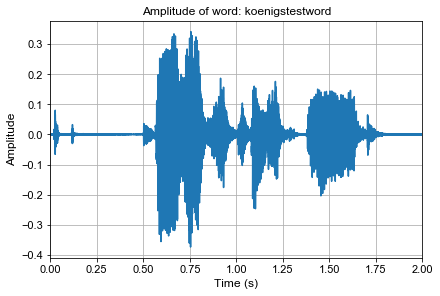

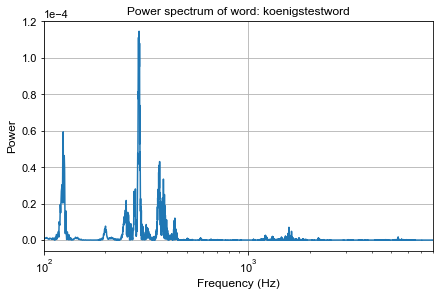

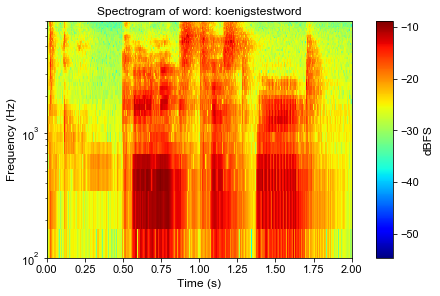

In [7]:
name = "koenigstestword"
rec, f_sampling = load_rec(name, play=False)
frequencies, times, spectrogram = plots(name, rec, f_sampling, save=True)

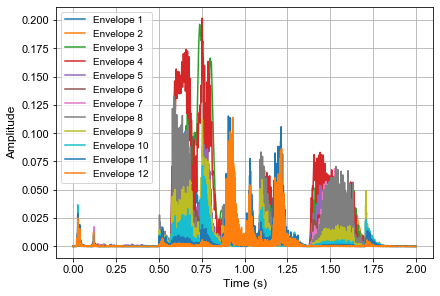

In [8]:
# filter sound in 12 electrode array
filtered_rec = ci_12.filter_sound(rec, order, f_sampling=f_sampling)
sd.play(filtered_rec[2])

# extract evelopes from filtered speech signal with hilbert transform
envelopes = abs(signal.hilbert(filtered_rec))

# plot envelopes
fig = plt.figure(constrained_layout=True)
i = 1
for envelope in envelopes:
    plt.plot(np.arange(len(envelope))*1/f_sampling, envelope, label=f"Envelope {i}")
    i += 1

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")   
plt.legend()
plt.show()
fig.savefig(f"../figures/envelopes.png", dpi=500)

##  Subtask 3 - Add Dynamic Compression

In [9]:
def compress_and_clip(envelope, low_thresh, rate=500):
    
    # compression step 
    env_compressed = np.log10(1+rate*envelope)/np.log10(rate+1)
    
    # clipping step
    for i in range(len(env_compressed)):
        if env_compressed[i] > 1: 
            env_compressed[i] = 1
        elif env_compressed[i] < low_thresh:
            env_compressed[i] = 0
    return env_compressed
            
processed_envs = []
low_thresh = 0.2
for envelope in envelopes:
    processed_env = compress_and_clip(envelope, low_thresh)
    processed_envs.append(processed_env)

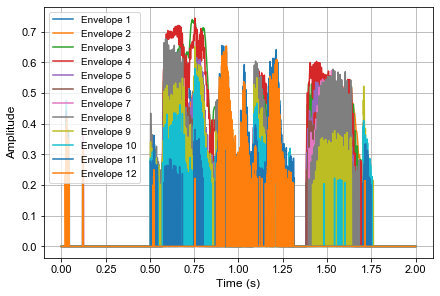

In [10]:
# plot processed envelopes
fig = plt.figure(constrained_layout=True)
i = 1
for envelope in processed_envs:
    plt.plot(np.arange(len(envelope))*1/f_sampling, envelope, label=f"Envelope {i}")
    i += 1

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")   
plt.legend()
plt.show()
fig.savefig(f"../figures/proc_envelopes.png", dpi=500)

In [11]:
# modulate noise with compression & clipping function 
noise_at_electrodes = np.array(noise_at_electrodes)
processed_envs = np.array(processed_envs)
modulation = np.multiply(noise_at_electrodes, processed_envs)

# sum the channels 
sum_modulation = np.sum(modulation, axis=0)
sd.play(sum_modulation)

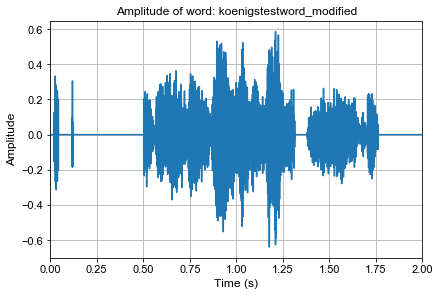

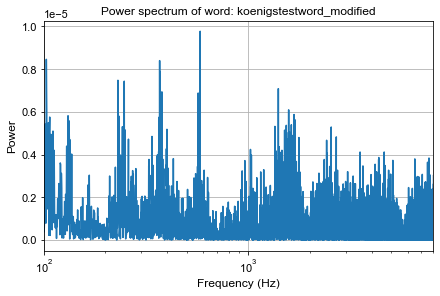

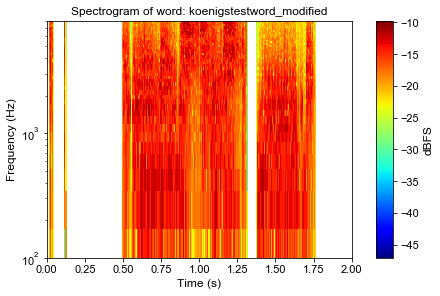

In [16]:
_ = plots(name+"_modified", sum_modulation, f_sampling, save=True)